**Nithun Selva and Saad Khan**

Spring 2025

CS 444: Deep Learning

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=4)

# Automatically reload your external source code
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<!-- # Project 3 | Word Embeddings and Sentiment Analysis -->
# Project 3 | Word Embeddings

The goal of this project is to gain insight about the representations learned by neural networks — how do they encode the training data internally? We will transition to training neural network on text data — specifically on tens of thousands of real Amazon reviews of fashion products (e.g. clothes, shoes, etc.). 

<!-- Next week, you will train a CNN to predict whether the reviews are positive or negative, a task in the field natural language processing (NLP) called **sentiment analysis**. -->

<!-- #### Week 1: Word Embeddings of Amazon Fashion Reviews -->

This notebook focuses on building the Amazon Fashion Reviews text preprocessing pipeline as well as analyzing and visualizing how a neural network learns to encode words from the reviews. You will train a **Continuous Bag of Words (CBOW)** (word2vec) neural network commonly used in the field of natural language processing (NLP) on text from IMDb user movie reviews. The network attempts to predict a **target word** (a missing word from a passage of text) from the surrounding **context words** (the words surrounding the target word in a sentence). After implementing and training the network, you will extract the weights to obtain $H$ dimensional **word embedding** vectors for English words that appeared in the Amazon reviews to analyze and visualize. 

## Task 1: Preprocessing Amazon Fashion Reviews

### 1a. Download and inspect first several few Amazon reviews

Download the Amazon Fashion dataset (`Amazon_Fashion.jsonl`) from the project website and store it in the `data` subfolder of your working directory. These Amazon reviews were curated by [the McAuley lab in 2023](https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023).

In the cell below, use the provided `load_reviews_and_ratings` function in `amazon_reviews.py` to load in the 1st five reviews and ratings. Print these first five reviews and clearly indicate the star rating for each review.

In [3]:
from amazon_reviews import load_reviews_and_ratings

In [3]:
# Code for task 1a
reviews, ratings = load_reviews_and_ratings(N_reviews=5)

# Print each review with its rating
for i, (review, rating) in enumerate(zip(reviews, ratings)):
    print(f"\n--- Review {i+1} (Rating: {rating} stars) ---")
    print(review[:200] + "..." if len(review) > 200 else review)



--- Review 1 (Rating: 5.0 stars) ---
I think this locket is really pretty. The inside back is a solid silver depression and the front is a dome that is not solid (knotted). You could use it to store a small photo, lock of hair, etc but I...

--- Review 2 (Rating: 5.0 stars) ---
Great

--- Review 3 (Rating: 2.0 stars) ---
One of the stones fell out within the first 2 weeks of wearing it. Stones smaller than expected.

--- Review 4 (Rating: 1.0 stars) ---
Crappy socks. Money wasted. Bought to wear with my tieks. Don’t stay on feet well.

--- Review 5 (Rating: 5.0 stars) ---
I LOVE these glasses!  They fit perfectly over my regular, rectangular glasses that I always have to wear in order to see.  I really appreciate having these pretty and stylish and sturdy sunglasses to...


### 1b. Make the corpus

We will use a "flat"/1D list of sentences across the reviews as our **corpus**. That is, we REMOVE information about which review a sentence came from in the corpus. However, we will eventually need this information in order to determine whether a review is positive/negative so we maintain a separate list that indicates to which review a given sentence belongs. For example: Sent 0 belongs to review 0, Sent 1 belongs to review 0, Sent 2 belongs to review 1, etc.

To make sure we have enough context words in sentences, we prune sentences that are too short. We also prune sentences that are too long.

Implement `make_corpus` in `amazon_reviews.py` to create the corpus of sentences and review ID associations.

In [7]:
from amazon_reviews import make_corpus

In [5]:
corpus, sentence_ratings, review_ids = make_corpus(N_reviews=50)
print(f'Number of sentences in the corpus (after pruning short sentences/identifying words): {len(corpus)}.')
print('There should be 185 sentences')
assert len(corpus) == len(sentence_ratings)
assert len(corpus) == len(review_ids)
print(f'The first few sent ratings are: {sentence_ratings[:10]} and should be [5. 5. 5. 5. 5. 2. 2. 1. 1. 1.]')
print(f'The last few sent ratings are: {sentence_ratings[-10:]} and should be [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]')
print(f'The first few review_ids are: {review_ids[:10]} and should be [0 0 0 0 0 2 2 3 3 3]')
print(f'The last few review_ids are: {review_ids[-10:]} and should be [49 49 49 49 49 49 49 49 49 49]')


Number of sentences in the corpus (after pruning short sentences/identifying words): 185.
There should be 185 sentences
The first few sent ratings are: [5. 5. 5. 5. 5. 2. 2. 1. 1. 1.] and should be [5. 5. 5. 5. 5. 2. 2. 1. 1. 1.]
The last few sent ratings are: [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.] and should be [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
The first few review_ids are: [0 0 0 0 0 2 2 3 3 3] and should be [0 0 0 0 0 2 2 3 3 3]
The last few review_ids are: [49 49 49 49 49 49 49 49 49 49] and should be [49 49 49 49 49 49 49 49 49 49]


### 1c. Make the vocabulary

We will be training a **word-level model**, so our tokens will be single words. Implement `find_unique_words` to form the **vocabulary**.

In [8]:
from amazon_reviews import find_unique_words

In [13]:
test_text = [['I', 'love', 'CS444'],
             ['I', 'love', 'deep', 'learning'],
             ['I', 'love', 'CS'],
             ['I', 'love', 'Colby']]
unique = find_unique_words(test_text)
print('unique words:\n', unique)
print("unique words should be:\n ['I', 'love', 'CS444', 'deep', 'learning', 'CS', 'Colby']")

unique_words_corpus = find_unique_words(corpus)
print(f'Number of unique words in the 50 reviews: {len(unique_words_corpus)} and should be 677.')


unique words:
 ['I', 'love', 'CS444', 'deep', 'learning', 'CS', 'Colby']
unique words should be:
 ['I', 'love', 'CS444', 'deep', 'learning', 'CS', 'Colby']
Number of unique words in the 50 reviews: 677 and should be 677.


### 1d. Mapping words to indices and back

While our corpus is currently made of word strings we clearly cannot plug these in as inputs to a neural network! We need to convert these word features to numbers first. For the specific CBOW word2vec neural network we are implementing, we *could plug in each word represented as a one-hot vector. To determine the location of the 1 in each vector, we use the word's position in the vocabulary. 

Implement and test `make_word2ind_mapping` to convert a string word to its position index in the vocab and `make_ind2word_mapping` to perform the reverse — looking up a string word based on its int index.

*For efficiency, we won't *actually* plug in one-hot vectors into CBOW. We'll use the int indices instead.

In [9]:
from amazon_reviews import make_word2ind_mapping, make_ind2word_mapping

In [15]:
print(f'For the test text, your word2ind mapping is:\n{make_word2ind_mapping(unique)}')
print('and it should be')
print("{'I': 0, 'love': 1, 'CS444': 2, 'deep': 3, 'learning': 4, 'CS': 5, 'Colby': 6}")
print()
print(f'The reverse ind2word mapping is:\n{make_ind2word_mapping(unique)}')
print('and it should be')
print("{0: 'I', 1: 'love', 2: 'CS444', 3: 'deep', 4: 'learning', 5: 'CS', 6: 'Colby'}")
print()

For the test text, your word2ind mapping is:
{'I': 0, 'love': 1, 'CS444': 2, 'deep': 3, 'learning': 4, 'CS': 5, 'Colby': 6}
and it should be
{'I': 0, 'love': 1, 'CS444': 2, 'deep': 3, 'learning': 4, 'CS': 5, 'Colby': 6}

The reverse ind2word mapping is:
{0: 'I', 1: 'love', 2: 'CS444', 3: 'deep', 4: 'learning', 5: 'CS', 6: 'Colby'}
and it should be
{0: 'I', 1: 'love', 2: 'CS444', 3: 'deep', 4: 'learning', 5: 'CS', 6: 'Colby'}



In [17]:
print(f'For the Amazon text, your word2ind mapping has :\n{len(make_word2ind_mapping(unique_words_corpus))} entries.')
print('and it should have\n677 entries.')
# Guessing this line isn't needed?
# print("{'I': 0, 'love': 1, 'CS444': 2, 'deep': 3, 'learning': 4, 'CS': 5, 'Colby': 6}")
print()
print(f'For the Amazon text, the reverse ind2word mapping has:\n{len(make_ind2word_mapping(unique_words_corpus))} entries.')
print('and it should have\n677 entries.')

For the Amazon text, your word2ind mapping has :
677 entries.
and it should have
677 entries.

For the Amazon text, the reverse ind2word mapping has:
677 entries.
and it should have
677 entries.


### 1e. Use the corpus to form context and target word tensors

Together, these make up the data samples and labels on which we will train the CBOW network. To form these tensors, we step through the corpus and identify each word as a target word and surrounding words within the **context window** as context words. To handle the fact that there are an irregular number of context words around each target words, we code samples as individual *pairs* of context and target words and we duplicate target words as needed. For example, for the target word `love` in `I love CS444`, we code add the target word entries of `1, 1` and add context word entries of `0, 2`.

In [10]:
from amazon_reviews import make_target_context_word_lists

Test: context window of 1

In [20]:
test_target_words_int, test_context_words_int = make_target_context_word_lists(test_text,
                                                                               make_word2ind_mapping(unique),
                                                                               context_win_sz=1)
print(f'For the test text, the int-coded target words are:\n{test_target_words_int.numpy()}')
print('and they should be:')
print('[0 1 1 2 0 1 1 3 3 4 0 1 1 5 0 1 1 6]')
print(f'For the test text, the int-coded context words are:\n{test_context_words_int.numpy()}')
print('and they should be:')
print('[1 0 2 1 1 0 3 1 4 3 1 0 5 1 1 0 6 1]')
# Make sure we have the correct dtype since these will eventually need to serve as indices
assert test_target_words_int.dtype == tf.int32
assert test_context_words_int.dtype == tf.int32

For the test text, the int-coded target words are:
[0 1 1 2 0 1 1 3 3 4 0 1 1 5 0 1 1 6]
and they should be:
[0 1 1 2 0 1 1 3 3 4 0 1 1 5 0 1 1 6]
For the test text, the int-coded context words are:
[1 0 2 1 1 0 3 1 4 3 1 0 5 1 1 0 6 1]
and they should be:
[1 0 2 1 1 0 3 1 4 3 1 0 5 1 1 0 6 1]


Test: Default context window of 2

In [21]:
test_target_words_int, test_context_words_int = make_target_context_word_lists(test_text,
                                                                               make_word2ind_mapping(unique))
print(f'For the test text, the int-coded target words are:\n{test_target_words_int.numpy()}')
print('and they should be:')
print('[0 0 1 1 2 2 0 0 1 1 1 3 3 3 4 4 0 0 1 1 5 5 0 0 1 1 6 6]')
print(f'For the test text, the int-coded context words are:\n{test_context_words_int.numpy()}')
print('and they should be:')
print('[1 2 0 2 0 1 1 3 0 3 4 0 1 4 1 3 1 5 0 5 0 1 1 6 0 6 0 1]')

For the test text, the int-coded target words are:
[0 0 1 1 2 2 0 0 1 1 1 3 3 3 4 4 0 0 1 1 5 5 0 0 1 1 6 6]
and they should be:
[0 0 1 1 2 2 0 0 1 1 1 3 3 3 4 4 0 0 1 1 5 5 0 0 1 1 6 6]
For the test text, the int-coded context words are:
[1 2 0 2 0 1 1 3 0 3 4 0 1 4 1 3 1 5 0 5 0 1 1 6 0 6 0 1]
and they should be:
[1 2 0 2 0 1 1 3 0 3 4 0 1 4 1 3 1 5 0 5 0 1 1 6 0 6 0 1]


Test: Amazon reviews

In [22]:
am_target_words_int, am_context_words_int = make_target_context_word_lists(corpus,
                                                                           make_word2ind_mapping(unique_words_corpus))
print(f'For the test text, there are {len(am_target_words_int)} int-coded target words and there should be 6930.')
print(f'For the test text, there are {len(am_context_words_int)} int-coded target words and there should be 6930.')

For the test text, there are 6930 int-coded target words and there should be 6930.
For the test text, there are 6930 int-coded target words and there should be 6930.


### 1f. Function to automate obtaining training samples and labels

Write `get_dataset_word2vec` to to streamline the process of going from the data file to getting the target and context word tensors.

In [11]:
from amazon_reviews import get_dataset_word2vec

In [24]:
targets_int, contexts_int, vocab = get_dataset_word2vec(N_reviews=40000)
print(f'Number of target words in actual Amazon corpus: {len(targets_int)}. There should be 5434338.')
print(f'Number of context words in actual Amazon corpus: {len(contexts_int)}. There should be 5434338.')
print(f'Vocab size in actual Amazon corpus: {len(vocab)}. It should be 21905.')

Number of target words in actual Amazon corpus: 5434338. There should be 5434338.
Number of context words in actual Amazon corpus: 5434338. There should be 5434338.
Vocab size in actual Amazon corpus: 21905. It should be 21905.


## Task 2: Build and train CBOW on Amazon Fashion Reviews

Now that we have the Amazon data in an appropriate format, let's develop the CBOW neural network. It should take far less time to develop this net due to its simplicity.

### 2a. Copy over your deep learning library from Project 2

Files to include are: `layers.py`, `block.py`, `network.py`, `tf_util.py`.

### 2b. Create the `DenseEmbedding` layer

This is the only new layer for CBOW, which itself is essentially just a `Dense` layer, but its inputs are used to *index* rather than *multiply* its weights. Implement the `DenseEmbedding` layer in `cbow_layers.py` then test your work below.

In [4]:
from cbow_layers import DenseEmbedding

#### Test: `DenseEmbedding` layer

In [32]:
tf.random.set_seed(0)
test_embed = DenseEmbedding('TestEmbedLayer', units=5)
tf.random.set_seed(1)
test_M = 10
test_embed(tf.random.uniform(shape=(1, test_M)))
print(f'Shape of wts/bias is {test_embed.get_wts().shape}/{test_embed.get_b().shape} and they should be (10, 5)/(5,)')
test_inds = tf.constant([2, 1, 0], dtype=tf.int32)
test_acts = test_embed(test_inds)
print(f'The netActs from forward pass:\n{test_acts.numpy()}')
print('and they should be:')
print('''[[-0.1744 -0.5512 -0.1061 -0.3297  0.3191]
 [-0.1547 -0.2417 -0.328  -0.3959  0.0067]
 [ 0.1275 -0.3441 -0.02    0.4227  0.2251]]''')

Shape of wts/bias is (10, 5)/(5,) and they should be (10, 5)/(5,)
The netActs from forward pass:
[[-0.1744 -0.5512 -0.1061 -0.3297  0.3191]
 [-0.1547 -0.2417 -0.328  -0.3959  0.0067]
 [ 0.1275 -0.3441 -0.02    0.4227  0.2251]]
and they should be:
[[-0.1744 -0.5512 -0.1061 -0.3297  0.3191]
 [-0.1547 -0.2417 -0.328  -0.3959  0.0067]
 [ 0.1275 -0.3441 -0.02    0.4227  0.2251]]


### 2c. Build CBOW architecture and implement forward pass

The CBOW network has the following structure:

Input → DenseEmbedding → Dense

Both the input and output layer have `vocab_sz` units. The output layer uses regular softmax activation.

Implement the following methods in the `CBOW` class in `cbow.py`:
- constructor
- `__call__`

In [5]:
from cbow import CBOW

#### Test: `CBOW` forward pass

In [34]:
tf.random.set_seed(0)
test_cbow = CBOW(C=5, input_feats_shape=(5,), embedding_dim=3)
test_cbow.compile()
test_inds = tf.constant([[1, 2, 3, 0]], dtype=tf.int32)
test_acts = test_cbow(test_inds)
print(f'The CBOW output layer netActs from the test indices are:\n{test_acts.numpy()}')
print('and they should be:')
print('''[[[0.1759 0.3235 0.0784 0.1804 0.2418]
  [0.1438 0.1019 0.2473 0.3665 0.1406]
  [0.2514 0.2696 0.1495 0.1182 0.2113]
  [0.261  0.1628 0.2505 0.1626 0.1631]]]''')

---------------------------------------------------------------------------
Dense layer output(Output) shape: [1, 5]
Dense layer output(Hidden) shape: [1, 3]
---------------------------------------------------------------------------
The CBOW output layer netActs from the test indices are:
[[[0.1759 0.3235 0.0784 0.1804 0.2418]
  [0.1438 0.1019 0.2473 0.3665 0.1406]
  [0.2514 0.2696 0.1495 0.1182 0.2113]
  [0.261  0.1628 0.2505 0.1626 0.1631]]]
and they should be:
[[[0.1759 0.3235 0.0784 0.1804 0.2418]
  [0.1438 0.1019 0.2473 0.3665 0.1406]
  [0.2514 0.2696 0.1495 0.1182 0.2113]
  [0.261  0.1628 0.2505 0.1626 0.1631]]]


The compile summary from the cell above should look like:
```
---------------------------------------------------------------------------
Dense layer output(Output) shape: [1, 5]
Dense layer output(Hidden) shape: [1, 3]
---------------------------------------------------------------------------
```

### 2d. Implement CBOW `fit`

Implement the CBOW `fit` method. This is a large-scale simplification of your existing `fit` method, since there is no validation set and no early stopping of any kind! I suggest copy-pasting your `DeepNetwork` fit method and paring down from there.

#### Test: Amazon dev set

Test out your `fit` method on a dev set created from the 1st 100 Amazon Fashion samples. Train a CBOW network with default hyperparameters for `100` epochs. The loss should drop from ~7.2 and stabilize to ~3.5.

In [ ]:
tf.random.set_seed(0)

dev_targets_int, dev_contexts_int, dev_vocab = get_dataset_word2vec(N_reviews=100)

# Create and compile CBOW model
dev_vocab_size = len(dev_vocab)
dev_net = CBOW(C=dev_vocab_size, input_feats_shape=(dev_vocab_size,))
# had to change lr to 1e-2 to get it to stabilize at ~3.5
dev_net.compile(optimizer='adam', lr=1e-2) 

# Train for 100 epochs
dev_loss_history = dev_net.fit(dev_contexts_int, dev_targets_int, epochs=100)

---------------------------------------------------------------------------
Dense layer output(Output) shape: [1, 1356]
Dense layer output(Hidden) shape: [1, 96]
---------------------------------------------------------------------------
Beginning training for 100 epochs with batch size 4096...
Epoch 1/100 - Loss: 7.1030 - Time: 0.77s
Epoch 2/100 - Loss: 6.4241 - Time: 0.07s
Epoch 3/100 - Loss: 5.8685 - Time: 0.07s
Epoch 4/100 - Loss: 5.7659 - Time: 0.08s
Epoch 5/100 - Loss: 5.5718 - Time: 0.06s
Epoch 6/100 - Loss: 5.4570 - Time: 0.06s
Epoch 7/100 - Loss: 5.2925 - Time: 0.06s
Epoch 8/100 - Loss: 5.1446 - Time: 0.07s
Epoch 9/100 - Loss: 4.9743 - Time: 0.06s
Epoch 10/100 - Loss: 4.8031 - Time: 0.07s
Epoch 11/100 - Loss: 4.6346 - Time: 0.07s
Epoch 12/100 - Loss: 4.4766 - Time: 0.07s
Epoch 13/100 - Loss: 4.3224 - Time: 0.06s
Epoch 14/100 - Loss: 4.1898 - Time: 0.07s
Epoch 15/100 - Loss: 4.0739 - Time: 0.07s
Epoch 16/100 - Loss: 3.9726 - Time: 0.06s
Epoch 17/100 - Loss: 3.8962 - Time: 0.07s

### 2e. Train CBOW on the Amazon reviews

In the cell below, train CBOW on the first `40,000` Amazon Fashion reviews for `35` epochs. You should use defaults for the other hyperparameters.

Create a plot showing the CBOW loss history over training epochs.

In [15]:
tf.random.set_seed(0)

targets_int, contexts_int, vocab = get_dataset_word2vec(N_reviews=40000)

# Create and compile CBOW model
vocab_size = len(vocab)
net = CBOW(C=vocab_size, input_feats_shape=(vocab_size,))
net.compile(optimizer='adam', lr=1e-3)

# Train for 35 epochs
loss_history = net.fit(contexts_int, targets_int, epochs=35)

---------------------------------------------------------------------------
Dense layer output(Output) shape: [1, 21905]
Dense layer output(Hidden) shape: [1, 96]
---------------------------------------------------------------------------
Beginning training for 35 epochs with batch size 4096...


W0000 00:00:1744754500.542103 2818038 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1744754508.048273 2818038 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 1/35 - Loss: 6.3442 - Time: 7.85s
Epoch 2/35 - Loss: 5.8614 - Time: 7.34s
Epoch 3/35 - Loss: 5.7620 - Time: 7.42s
Epoch 4/35 - Loss: 5.7053 - Time: 7.38s
Epoch 5/35 - Loss: 5.6658 - Time: 7.47s
Epoch 6/35 - Loss: 5.6355 - Time: 7.40s
Epoch 7/35 - Loss: 5.6110 - Time: 7.36s
Epoch 8/35 - Loss: 5.5904 - Time: 7.34s
Epoch 9/35 - Loss: 5.5727 - Time: 7.43s
Epoch 10/35 - Loss: 5.5574 - Time: 7.38s
Epoch 11/35 - Loss: 5.5438 - Time: 7.32s
Epoch 12/35 - Loss: 5.5317 - Time: 7.31s
Epoch 13/35 - Loss: 5.5209 - Time: 7.33s
Epoch 14/35 - Loss: 5.5110 - Time: 7.29s
Epoch 15/35 - Loss: 5.5021 - Time: 7.46s
Epoch 16/35 - Loss: 5.4940 - Time: 7.42s
Epoch 17/35 - Loss: 5.4866 - Time: 7.32s
Epoch 18/35 - Loss: 5.4799 - Time: 7.24s
Epoch 19/35 - Loss: 5.4738 - Time: 7.28s
Epoch 20/35 - Loss: 5.4682 - Time: 7.30s
Epoch 21/35 - Loss: 5.4632 - Time: 7.33s
Epoch 22/35 - Loss: 5.4587 - Time: 7.30s
Epoch 23/35 - Loss: 5.4545 - Time: 7.34s
Epoch 24/35 - Loss: 5.4508 - Time: 7.29s
Epoch 25/35 - Loss: 5.447

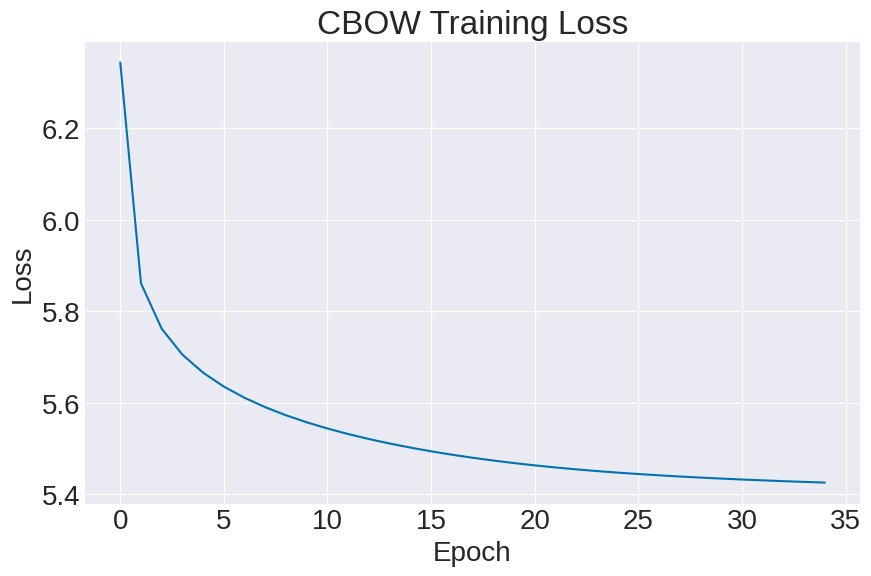

In [16]:
# Plot loss history
plt.figure(figsize=(10, 6))
plt.plot(loss_history)
plt.title('CBOW Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

### 2f. Get and save embeddings

To prevent having to retrain the CBOW network every time you want to access or analyze the word embeddings, I am providing a method `save_embeddings` that saves the network embeddings to disk in subfolder `export` in your working directory. 

<!-- **You will need to save your embeddings for sentiment analysis net week.**  -->

Here is how you would load the embeddings in the future after saving them:

```python
loaded_embeddings = np.load('export/embeddings.npz')
loaded_embeddings = loaded_embeddings['embeddings']
```

The `save_embeddings` method and forthcoming analysis will require getting all the embeddings from the network (`get_all_embeddings`) or only the embedding for one specific word (`get_word_embedding`). In `cbow.py`, write these methods.

#### Test: `get_all_embeddings` and `get_word_embedding`

In [17]:
tf.random.set_seed(0)
test_net = CBOW(input_feats_shape=(3,), C=3, embedding_dim=5)
test_net.compile()
print('All the embeddings are:')
print(test_net.get_all_embeddings().numpy())
print('and they should be:')
print('''[[ 0.8724  0.2442 -0.2423 -0.5982 -0.7141]
 [ 0.2715 -0.0081  0.6864  0.3479  0.3462]
 [-0.4074 -0.25    0.4582 -0.4027 -0.5542]]''')
print('The embedding for index 1 is')
print(test_net.get_word_embedding(1).numpy())
print('and it should be:')
print('''[ 0.2715 -0.0081  0.6864  0.3479  0.3462]''')

---------------------------------------------------------------------------
Dense layer output(Output) shape: [1, 3]
Dense layer output(Hidden) shape: [1, 5]
---------------------------------------------------------------------------
All the embeddings are:
[[ 0.8724  0.2442 -0.2423 -0.5982 -0.7141]
 [ 0.2715 -0.0081  0.6864  0.3479  0.3462]
 [-0.4074 -0.25    0.4582 -0.4027 -0.5542]]
and they should be:
[[ 0.8724  0.2442 -0.2423 -0.5982 -0.7141]
 [ 0.2715 -0.0081  0.6864  0.3479  0.3462]
 [-0.4074 -0.25    0.4582 -0.4027 -0.5542]]
The embedding for index 1 is
[ 0.2715 -0.0081  0.6864  0.3479  0.3462]
and it should be:
[ 0.2715 -0.0081  0.6864  0.3479  0.3462]


Run/adapt the following cell to save your embeddings to disk (`net` is your net trained on the reviews).

In [18]:
net.save_embeddings()

## Task 3: Visualizing word embeddings with t-SNE

In this task, you will use the **cosine similarity** metric to find the words that have the most similar embedding to some query words of your choice. You will use the [t-SNE dimensionality reduction algorithm ](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) built into scikit-learn to visualize in 2D the relative positioning of the query word and words with the highest cosine similarity.

### 3a. Implement cosine similarity to get the most similar words to a query word

Given a word that we are interested in, the cosine similarity will find the $k$ words that have the most similar embeddings to that of the query word.

Here is a refresher on the cosine similarity equation:

$$
\text{Cosine Similarity} = \frac{(\text{Wts})(\vec{w})}{\sqrt{\sum_{j=1}^H (\text{Wts}^T)_j^2} \sqrt{\sum_{j=1}^H w_j^2}}
$$

Where $\text{Wts}$ are all the embeddings, $\text{Wts}^T$ is the transpose of the embeddings, $\vec{w}$ is the word embedding vector for the query word.


In [ ]:
from amazon_reviews import get_most_similar_words

#### Test: `get_most_similar_words`

In [ ]:
test_word_str2int = {
                     'Waterville': 0,
                     'Acadia': 1,
                     'Camden': 2,
                     'Portland': 3,
                     'Boothbay': 4,
                     'Bangor': 5,
                     'Kennebunkport': 6
                    }
test_word_int2str = {
                     0: 'Waterville',
                     1: 'Acadia',
                     2: 'Camden',
                     3: 'Portland',
                     4: 'Boothbay',
                     5: 'Bangor',
                     6: 'Kennebunkport'
                    }

test_word_str = 'Waterville'
tf.random.set_seed(0)
test_embeddings = tf.random.uniform(shape=(7, 4)).numpy()
test_top_inds, test_top_sims = get_most_similar_words(k=3,
                                                      all_embeddings=test_embeddings,
                                                      word_str=test_word_str,
                                                      word_str2int=test_word_str2int)

print(f'Words most similar to {test_word_str}:')
for k0 in range(len(test_top_inds)):
    print(f'{k0}: {test_word_int2str[test_top_inds[k0]]} (similarity={test_top_sims[k0]:.4f})')

### 3b. Use t-SNE to perform dimensionality reduction on the embeddings.

In the cell below:
1. Use [scikit-learn's TSNE class](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to reduce the dimensionality of the learned Amazon word embeddings down to 2D so that we will be able to visualize them in a scatter plot.
2. Assign the original embeddings to a variable `embeddings`.
3. Assign the 2D embeddings to a variable `word_tnse`. Make sure `embeddings` is a NumPy ndarray rather than a TF tensor.

In [ ]:
from sklearn.manifold import TSNE
from amazon_reviews import find_unique_word_counts

### 3c. Create word cloud from Amazon Fashion review embeddings

In the cell below:

1. Name the word string-to-int map `word2ind` and the word index int-to-string map `ind2word` for the Amazon Fashion dataset.
2. Name the vocabulary for the Amazon Fashion dataset `vocab`.

Pick a word for `query_word` (has it be in the vocab) and run the cell below to show the words with the 25 most similar embeddings as well as a scatter plot, which shows all the word embeddings but annotates the query word and the most similar words.

**Note:** At least to start, pick query words among those that appear the most in the corpus. Code two cells down lists these most frequent words.

In [ ]:
query_word = 'great'
topk_word_inds, topk_cossim = get_most_similar_words(k=25,
                                                     all_embeddings=embeddings,
                                                     word_str=query_word,
                                                     word_str2int=word2ind)


word_strs = [ind2word[ind] for ind in topk_word_inds]

print(f'Words most similar to {query_word}:')
for k0 in range(len(topk_word_inds)):
    print(f'{k0}: {ind2word[topk_word_inds[k0]]} (similarity={topk_cossim[k0]:.4f})')

# Visualize word cloud — each word as (x, y) coords
plt.figure(figsize=(40, 40))
plt.scatter(word_tnse[:, 0], word_tnse[:, 1])

max_xy = 5
rng = np.random.default_rng(0)
offsets = rng.uniform(low=-max_xy, high=max_xy, size=(len(word_strs), 2))
for w in range(len(word_strs)):
    plt.annotate(word_strs[w], (word_tnse[w, 0]+offsets[w,0], word_tnse[w, 1]+offsets[w,0]), fontsize=30)

plt.title('Word Embeddings (2D t-SNE)')
plt.xlabel('Embedding dim 1')
plt.ylabel('Embedding dim 2')
plt.show()

Print the words that appear most often in the Amazon Fashion corpus.

In [ ]:
# TODO: modify variable name `corpus` to refer to your Amazon Fashion corpus
unique_word_counts = find_unique_word_counts(corpus=corpus)
top_k = 100

print(f'Top {top_k} words (by count in corpus):')
i = 0
for word, count in unique_word_counts.items():
    print(word, count)
    i += 1

    if i > top_k:
        break

### 3d. Questions

**Question 1:** Have some fun looking up word similarities. Which similarities do you like best / find the most interesting?

**Question 2:** Do the most similar words tend to show up nearby or far from one another in the word cloud?

**Question 3:** Why does the quality of the similar words improve for words that are more frequent in the corpus?

**Answer 1:** 

**Answer 2:** 

**Answer 3:** 

## Extensions

### General guidelines

1. Never integrate extensions into your base project so that they change the expected behavior of core functions. If your extension changes the core design/behavior, no problem, duplicate your working base project and add features from there.
2. Check the rubric to keep in mind how extensions on this project will be graded.
3. While I may consult your code and "written log" of what you did, **I am grading your extensions based on what you present in your 3-5 min video.**
3. I suggest documenting your explorations in a "log" or "lab notebook" style (i.e. documenting your thought/progression/discovery/learning process). I'm not grading your writing, so you can keep it succinct. **Whatever is most useful to you to remember what you did.** 
4. I suggest taking a hypothesis driven approach. For example "I was curious about X so I explored Y. I found Z, which was not what I expected because..., so then tried A..."
5. Make plots to help showcase your results.
6. **More is not necessarily better.** Generally, a small number of "in-depth" extensions count for more than many "shallow" extensions.

### AI guidelines

You may use AI in mostly any capacity for extensions. However, keep in mind:
1. There is no need to use AI at all!
2. You are welcome to use AI as a tool (e.g. automate something that is tedious, help you get unstuck, etc.). However, you should be coding, you should be thinking, you should be writing, you should be creating. If you are spending most (or even close to most) of your time typing into a chatbot and copy-pasting, you have probably gone too far with AI use.
3. I don't find large volumes of AI generated code/text/plots to be particularly impressive and you risk losing my interest while grading. Remember: I'm grading your extensions based on your video presentation. **More is not necessarily better.**

### Video guidelines

1. Please try to keep your video to 5 minutes (*I have other projects to grade!*). If you turn in a longer video, I make no promise that I will watch more than 5 minutes.
2. Your screen should be shared as you show me what you did. A live video of your face should also appear somewhere on the screen (e.g. picture-in-picture overlay / split screen).
3. Your partner should join you for the video and take turns talking, but, if necessary, it is fine to have one team member present during the record the video.
4. Do not simply read text from your notebook, do not read from a prepared script. I am not grading how polished your video presentation is (see extension grading criteria on rubric). 
5. I am looking for original and creative explorations sparked by your curiosity/interest/passion in a topic. This should be apparent in your video.
6. Be natural,, don't feel the need to impress me with fancy language. If it is helpful, imagine that we are talking one-on-one about your extension. Tell me what you did :)

### Extension ideas

#### 1. Analyze effect of embedding dimension

- Systematically vary the embedding dimension. How does the embedding dimension affect the quality of similar words based on their embeddings / cosine similarity?

#### 2. Amount of data

How does the size of the dataset (number of reviews) affect the quality of the embeddings?

#### 3. Improve text preprocessing

Try implementing and seeing how any of the following may change the quality of embeddings:

**Stemming:** Currently words with different suffixes are treated the same — e.g. "run", "runs", "running", etc. Normalize these so they map the same word.

**Remove stop words:** Remove common "filler" words that have little meaning — e.g. "a", "the", "an", etc.

**Misspelled words**: There are numerous misspellings of words in the corpus. Does having them in the vocab help or hurt?

If things improve/worsen, why might this be the case?

#### 4. Other text dataset of your choice

Obtain and preprocess a text dataset of your choice. Then either train on CBOW and visualize/analyze embeddings.

#### 5. Sentiment analysis

(*This is a more involved/challenging extension*) Use the word embedding vectors as data samples into another neural network whose job it is to predict whether either the word or the Amazon review to which it and other words in the review belong is positive (say >3 star rating) or negative (say < 3 star rating). 

For predicting the sentiment of words, you can use a simple heuristic to get the +/- label for individual words: If the word belongs to more + reviews than - reviews, then the word is a + word (and vice versa).

#### 6. Other dimensionality reduction techniques

Explore how different dimensionality reduction techniques alter the visualization/clustering of the words. *Keep in mind that many algorithms have hyperparameters and if one algorithm gives poor results, you should explore other hyperparameter values before concluding the algorithm does a poor job.*

Some popular ideas:
- PCA
- UMAP
- Self-organizing map (SOM)